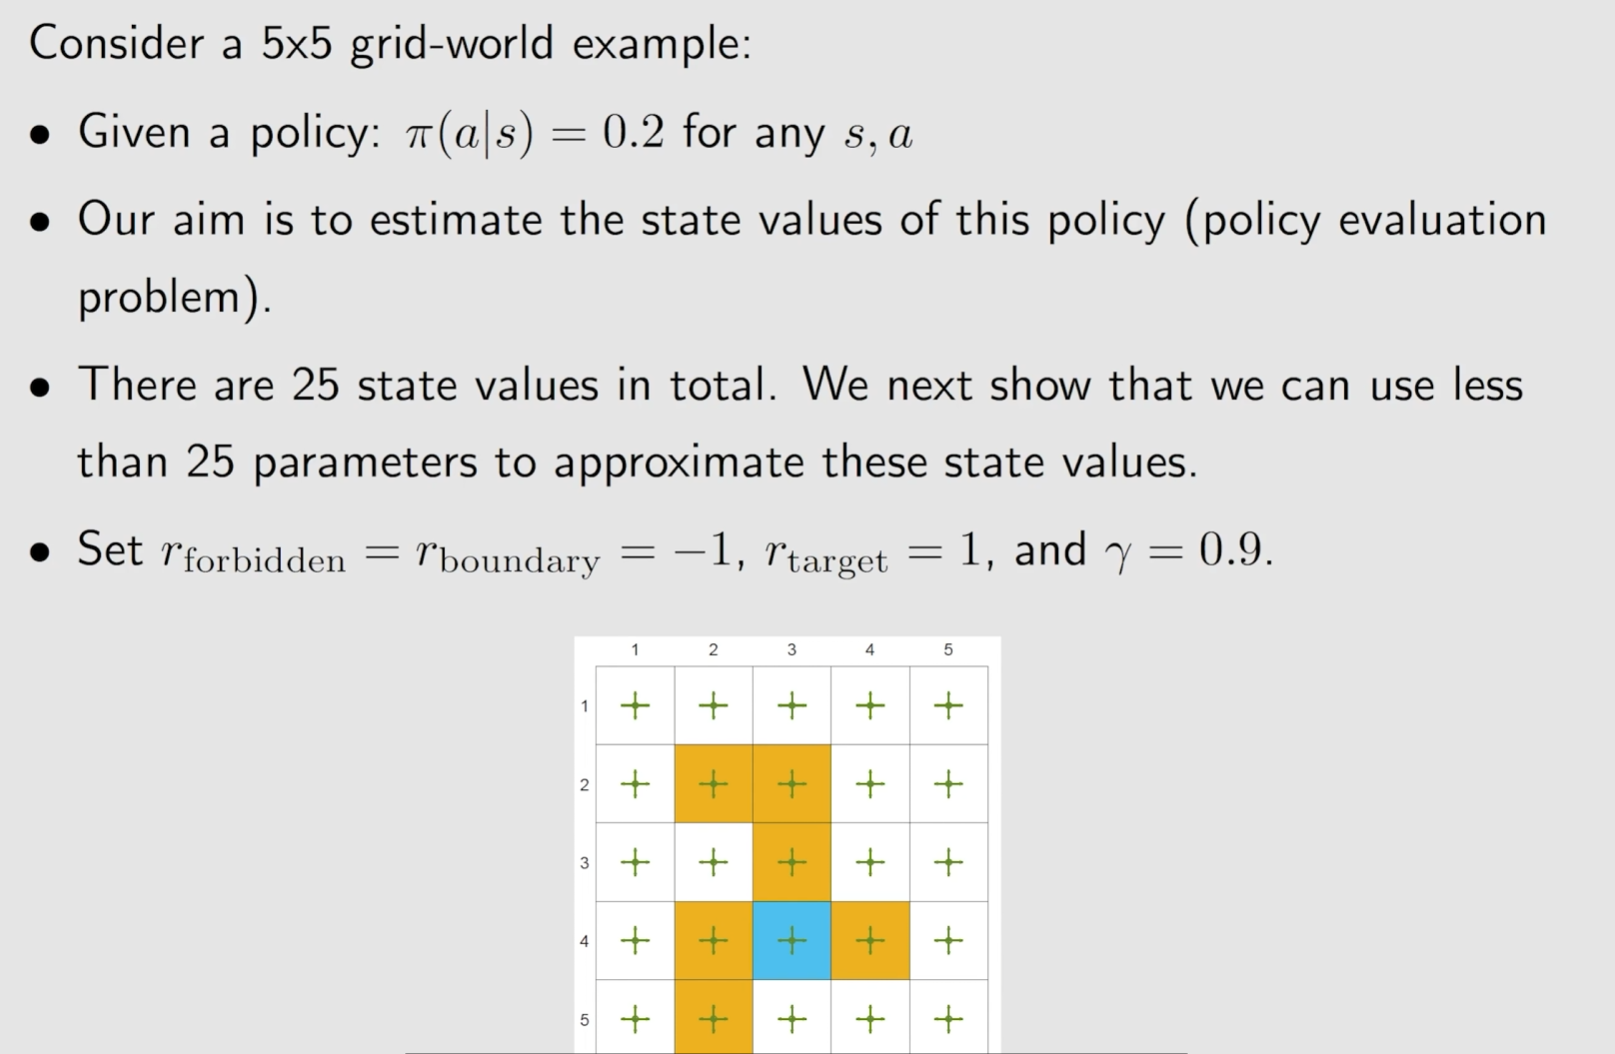


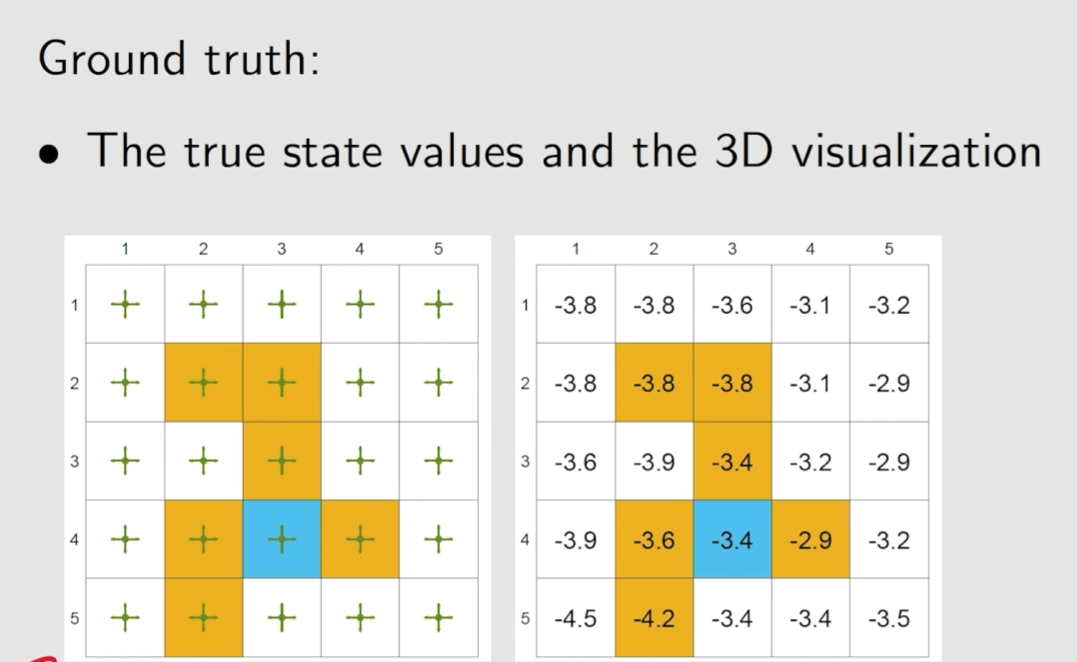

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from generate_episode import gen_multi_grid_episodes
%matplotlib inline
# %matplotlib qt

In [19]:
ground_truth = np.array([[-3.8, -3.8, -3.6, -3.1, -3.2],
                         [-3.8, -3.8, -3.8, -3.1, -2.9],
                         [-3.6, -3.9, -3.4, -3.2, -2.9],
                         [-3.9, -3.6, -3.4, -2.9, -3.2],
                         [-4.5, -4.2, -3.4, -3.4, -3.5]])
n_actions = 5
grid_edge_length = 5
n_state = ground_truth.size    
forbidden_state = [7 ,8, 13, 17, 19, 22]     
# pi's shape: (25, 5)
pi = np.zeros(shape=(n_state, n_actions)) + 0.2
r_forbid = -1
r_bound = -1
r_normal = 0
r_tgt = 1
gamma = 0.9

episodes = gen_multi_grid_episodes(n_episodes=500, pi=pi, episode_length=500, grid_edge_length=grid_edge_length,
                                   forbidden_state=forbidden_state, tgt_state=18, r_normal=r_normal, r_bound=r_bound, r_forbid=r_forbid, r_tgt=r_tgt, mode="srs")
print(len(episodes))  

500


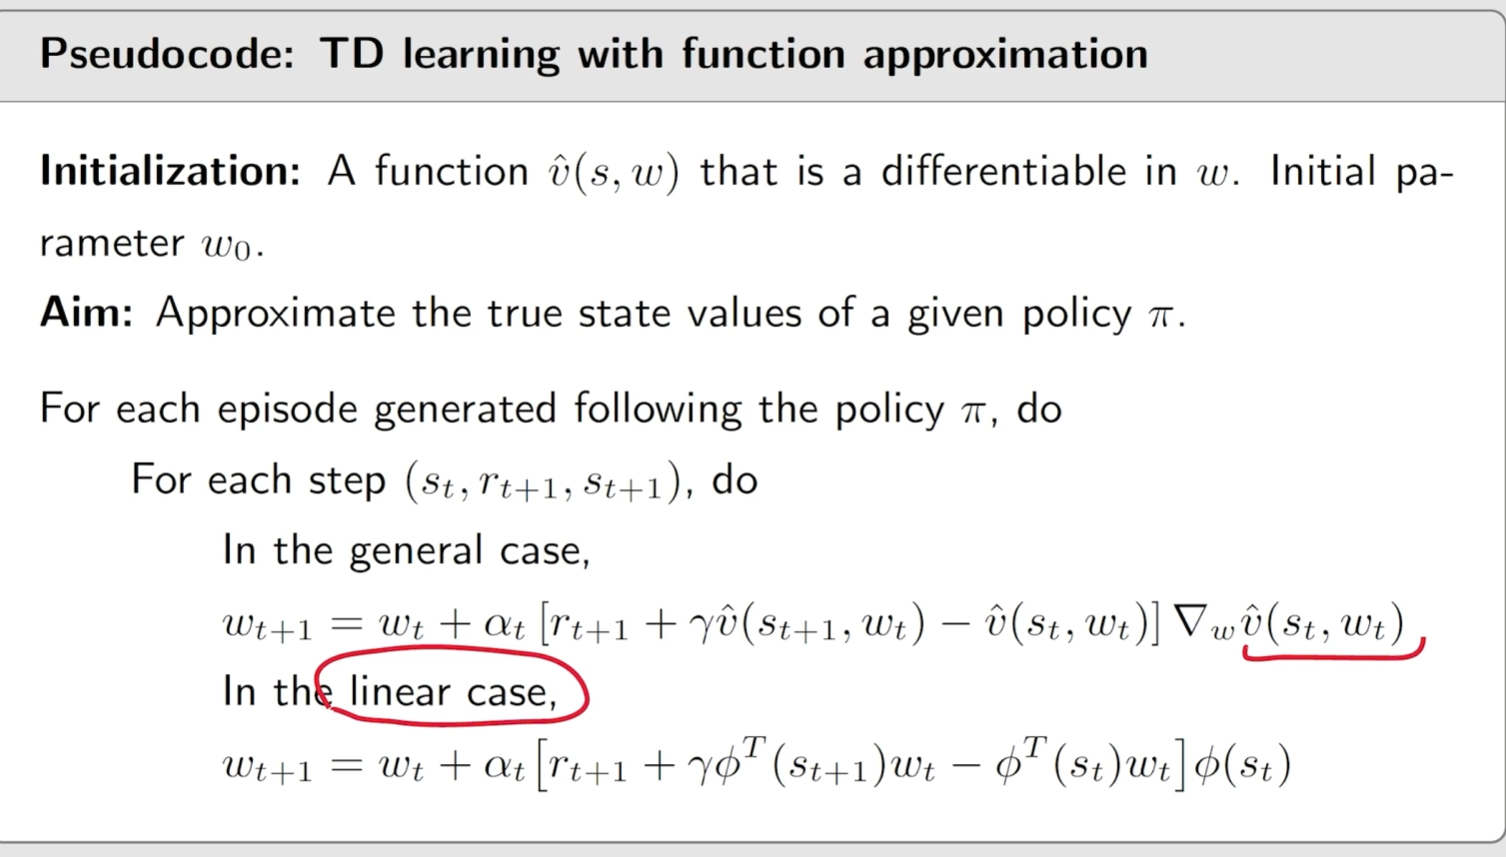

In [20]:
def calculate_v_hat_and_grad(s, w, phi_order=3):
    # v_hat = φ(s).T @ w
    x, y = s
    phi_dic = {3:[1, x ,y], 6:[1, x, y, x**2, y**2, x*y], 10:[1, x, y, x**2, y**2, x*y, x**3, y**3, (x**2)*y, x*(y**2)]}
    phi_s = np.asarray(phi_dic[phi_order]).reshape(-1,1)
    return phi_s.T @ w, phi_s


def get_num(item):
    return int(item.split("_")[-1])

def trans_state2ij(item, gird_edge_length):
    """
    把状态一维索引转换为二维索引, i,j = (0~24)
    """
    state = get_num(item)
    mod = state % gird_edge_length
    j = mod if mod != 0 else 5
    i = int(((state - j) / gird_edge_length) + 1)
    return (i-1, j-1)


def visual_3d(data, z_min=-5, z_max=-2):
    # 假设 pred 已经有数据
    # pred = np.random.rand(5, 5)  # 示例数据替代你的 pred 数组

    # 生成坐标网格（假设是 5x5 的二维数组）
   
    
    x = np.arange(0, 5)
    y = np.arange(0, 5)
    X, Y = np.meshgrid(x, y)  # 生成网格坐标
    Z = data  # 你的二维数组

    # 创建三维画布
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制表面图
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='k', linewidth=0.5)

    # 固定z轴取值范围
    ax.set_zlim(z_min, z_max)

    # 添加颜色条和标签
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_xlabel('row')
    ax.set_ylabel('column')
    ax.set_zlabel('Value')
    ax.set_title('3D Surface Plot')

    # 启用交互模式，允许图表旋转
    plt.ion()

    # 显示图形
    plt.show()

    # 保持图表直到关闭窗口
    plt.ioff()
    
def visual_error(x, y, alpha):
    # %matplotlib inline
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    ax.plot(x, y, label=f"TD-Linear:α={alpha}")
    ax.set_xlabel("Episode Index")
    ax.set_ylabel("State Value error(RMSE)")
    ax.legend()
    plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_15300\1646417626.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i, j] = v


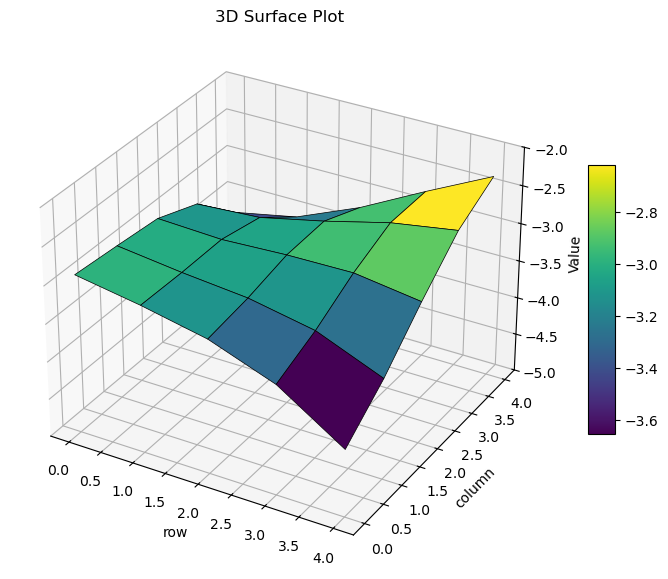

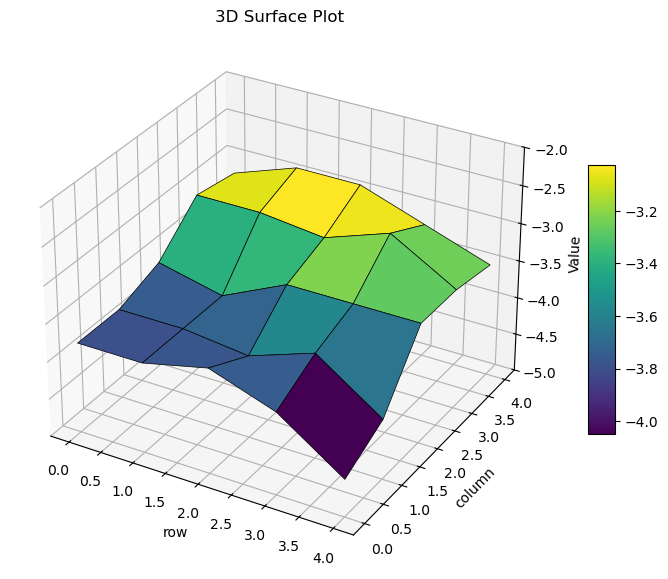

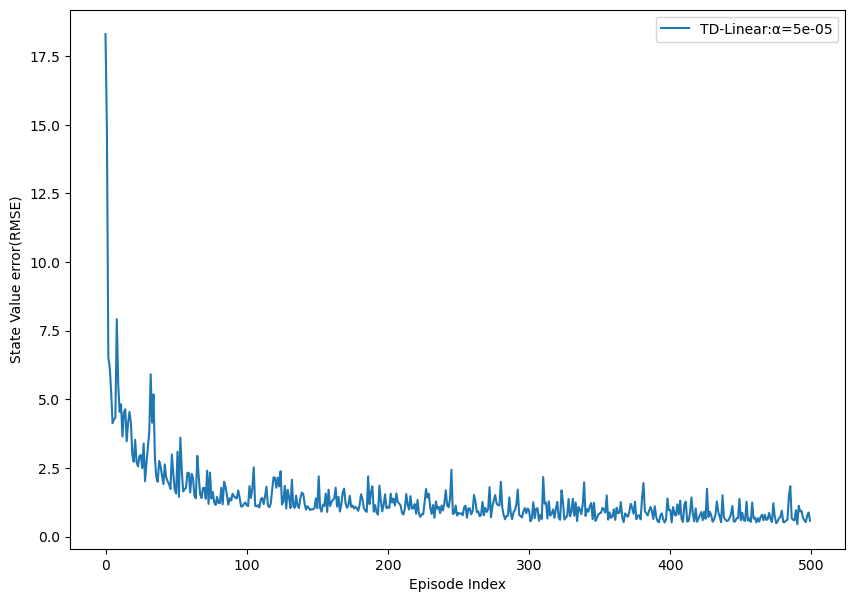

0.5805376196784177
[[-2.90462505 -2.95228582 -3.00721245 -3.22052597 -3.7433474 ]
 [-3.04771671 -3.05709735 -3.04661369 -3.16738675 -3.57053755]
 [-3.2249441  -3.13961116 -3.00728375 -2.97908289 -3.2061296 ]
 [-3.54283227 -3.3063523  -2.99574768 -2.76213945 -2.75664863]
 [-4.1079063  -3.66384583 -3.11853055 -2.62308149 -2.32861968]]
[[-3.8 -3.8 -3.6 -3.1 -3.2]
 [-3.8 -3.8 -3.8 -3.1 -2.9]
 [-3.6 -3.9 -3.4 -3.2 -2.9]
 [-3.9 -3.6 -3.4 -2.9 -3.2]
 [-4.5 -4.2 -3.4 -3.4 -3.5]]
0.5805376196784177


In [36]:
phi_order = 10
w = np.random.normal(size=(phi_order, 1))
alpha = 5e-5
error_ls = []
for i in range(len(episodes)):
    for j, trajectory in enumerate(episodes[i]):
        # srs
        s_t = trans_state2ij(trajectory[0], grid_edge_length)
        r_next_t = get_num(trajectory[1])
        s_next_t = trans_state2ij(trajectory[2], grid_edge_length)

        v_t_hat, v_t_grad= calculate_v_hat_and_grad(s_t, w, phi_order)
        v_next_t_hat, _ = calculate_v_hat_and_grad(s_next_t, w, phi_order)

        # w = w + (alpha/(j+1)) * v_t_grad * (r_next_t + gamma * v_next_t_hat - v_t_hat)
        w = w + alpha * v_t_grad * (r_next_t + gamma * v_next_t_hat - v_t_hat)
    pred = np.empty_like(ground_truth)
    for i in range(grid_edge_length):
        for j in range(grid_edge_length):
            v, _ = calculate_v_hat_and_grad((i+1,j+1), w, phi_order)
            pred[i, j] = v
    error = (((pred - ground_truth)**2).sum() / n_state) ** 0.5
    error_ls.append(error)

visual_3d(pred)
visual_3d(ground_truth)
visual_error(range(len(episodes)), error_ls, alpha)
print(error_ls[-1])
print(pred)
print(ground_truth)
print(error)